# CRAG: Corrective RAG

- Author: [Jaeho Kim](https://github.com/Jae-hoya)
- Design: []()
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

## OverView


**The Corrective RAG (CRAG)** strategy focuses on improving RAG-based systems.
**CRAG** is an approach that refines the search-generation pipeline by incorporating self-reflection and self-evaluation phases for the retrieved documents.

![crag](./assets/03-Langgraph-CRAG.png)



**What is CRAG ?**

**Corrective-RAG (CRAG)** is a methodology in the RAG (Retrieval-Augmented Generation) strategy that **adds a step to evaluate the retrieved documents and refine the knowledge.** This approach involves reviewing the search results before generation, conducting supplementary searches if necessary, and ultimately includes a series of processes to produce high-quality responses.

The core ideas of CRAG are as follows:

[Link to the paper (Corrective Retrieval-Augmented Generation)](https://arxiv.org/pdf/2401.15884.pdf)

1. If one or more of the retrieved documents exceed the predefined relevance threshold (retrieval validation score), the process proceeds to the generation stage.
2. A knowledge refinement step is performed before generation.
3. Documents are divided into "knowledge strips" (where `k` refers to the number of document retrieval results).
4. Each knowledge strip is evaluated, and its relevance is scored (evaluations are conducted at the document chunk level).
5. If all documents fall below the relevance threshold or the evaluation results have low confidence, additional data sources (e.g., web searches) are used for supplementation.
6. When supplementing through web searches, query results are optimized using `Query-Rewrite`.
---

**Key Points**


This tutorial demonstrates implementing some of the ideas from the `CRAG` approach using LangGraph.

Here, **the knowledge refinement step is omitted** but is designed to be added as a node if necessary.

Additionally, **if no relevant documents are found**, `web searches` will be used to supplement the retrieval.

For **web searches**,  [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/) will be utilized, and Question Rewrite will be introduced to optimize the search process.

---

**Overview of Key Steps**

- **Retrieval Grader**: Evaluate the relevance of the retrieved documents.
- **Generate**: Generate answers using LLM.
- **Question Re-writer**: Optimize search queries by rewriting the question.
- **Web Search Tool**: Utilize Tavily Search for web searches.
- **Create Graph**: Create a CRAG strategy graph using LangGraph.
- **Use the graph**: Learn how to utilize the generated graph.




### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Creating a Basic PDF-Based Retrieval Chain](#creating-a-basic-pdf-based-retrieval-chain)
- [Relevance Evaluation of Retrieved Documents (Question-Retrieval Evaluation)](#relevance-evaluation-of-retrieved-documents-question-retrieval-evaluation)
- [Answer Generation Chain](#answer-generation-chain)
- [Question Re-write](#question-re-write)
- [Web search tool](#web-search-tool)
- [State](#state)
- [Node](#node)
- [Function for Conditional Edges](#function-for-conditional-edges)
- [Graph Creation](#graph-creation)
- [Graph Execution](#graph-execution)



---

### References

- [LangGraph: Corrective RAG (CRAG) using local LLMs](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/)
- [LangSmith: RAG Prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- [Langchain: stream_mode](https://python.langchain.com/docs/how_to/qa_streaming/)

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "pydantic",
        "langsmith",
        "langchain",
        "langchain_community",
        "pdfplumber",
        "faiss-cpu",
        "langchain_core",
        "langchain_openai",
        "langgraph"
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "TAVILY_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "03-LangGraph-CRAG",
    }
)

Environment variables have been set successfully.


In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Creating a Basic PDF-Based Retrieval Chain

We will create a Retrieval Chain based on PDF documents. This represents the simplest structure of a Retrieval Chain.

Note that in LangGraph, the Retriever and Chain are created separately. This allows for detailed processing at each node.

**Note**

- This was covered in a previous tutorial, so detailed explanations are omitted.

In [5]:
from rag.pdf import PDFRetrievalChain

#Load PDF documents
pdf = PDFRetrievalChain(["./data/Newwhitepaper_Agents2.pdf"]).create_chain()

# Create the retriever and chain.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## Relevance Evaluation of Retrieved Documents (Question-Retrieval Evaluation)

The relevance evaluation of retrieved documents is the step where the retrieved documents are assessed for their relevance to the question.

First, create an evaluator (`retrieval-grader`) to assess the retrieved documents.

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# Data Model for Binary Scoring of Document Relevance
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # A field indicating whether the document is relevant to the question, represented as 'yes' or 'no'
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM initialization
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# An LLM that generates structured outputs using the GradeDocuments data model.
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Define system prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# Create chat prompt template
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Initialize retrieval evaluator
retrieval_grader = grade_prompt | structured_llm_grader

Using `retrieval_grader`, documents are evaluated.

Here, the evaluation is performed on a single document rather than a set of documents.

The result returns the relevance of the single document as either **yes** or **no** .

In [7]:
# Define question
question = "How do agents differ from standalone language models?"

# Document retrieval
docs = pdf_retriever.invoke(question)

# Extract Content of Page from Document at Index 1
doc_txt = docs[1].page_content

# Run Relevance Evaluation Using Retrieved Documents and Question
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


## Answer Generation Chain

The answer generation chain is a chain that generates answers based on the retrieved documents.

It is a typical Naive RAG chain that we are familiar with.

**Note**

RAG Prompt from LangChain PromptHub: https://smith.langchain.com/hub/rlm/rag-prompt

In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# Using RAG Prompt from LangChain Hub
prompt = hub.pull("rlm/rag-prompt")

# Initialize LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Document formatting
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# Create chain
rag_chain = prompt | llm | StrOutputParser()


# Run chain and output results
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Agents differ from standalone language models in that they can leverage external tools to access real-time information and perform complex tasks autonomously. While language models are limited to their training data, agents can extend their knowledge and capabilities by interacting with external systems. This allows agents to execute actions and make decisions beyond the static knowledge of a standalone model.


## Question Re-write

Query rewriting is a step where the question is rewritten to optimize web searches.

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Query rewrite system prompt
system = """You a question re-writer that converts an input question to a better version that is optimized 
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Define prompt
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Define question rewriter chain
question_rewriter = re_write_prompt | llm | StrOutputParser()

Rewrite Question Using `question_rewriter`.

In [10]:
# Run chain and output results
print(f'[Original question]: "{question}"')
print("[Query-rewrite]:", question_rewriter.invoke({"question": question}))

[Original question]: "How do agents differ from standalone language models?"
[Query-rewrite]: What are the key differences between agents and standalone language models?


## Web search tool

**Web search tool** is used to supplement the context.

- **Need for Web Search**: When all documents fail to meet the relevance threshold or the evaluator lacks confidence, additional data is retrieved through web searches.
- **Using Tavily Search**: Perform web searches using Tavily Search, which optimizes search queries and provides more relevant results.
- **Question Rewrite**: Improve search queries by rewriting the question to optimize web searches.

In [11]:
# Initialize Web Search Tool
from langchain.tools.tavily_search import TavilySearchResults

# Set maximum search results to 3
web_search_tool = TavilySearchResults(max_results=3)

In [12]:
# Execute web search tool
results = web_search_tool.invoke({"query": question})
print(results)

[{'url': 'https://digitalspoiler.com/trends-insights/unlocking-the-power-of-generative-ai-agents-what-you-need-to-know/', 'content': 'The central decision-maker powered by language models (LMs). These models leverage frameworks like ReAct, Chain-of-Thought, or Tree-of-Thought to reason and make informed decisions. ... How Agents Differ from Models. While standalone AI models rely on static training data, agents dynamically enhance their knowledge by connecting with external'}, {'url': 'https://blog.stackademic.com/introduction-to-ai-agents-bridging-models-and-real-world-applications-ed0ca6c25f2a', 'content': 'Introduction to AI Agents: Bridging Models and Real-World Applications | by allglenn | Jan, 2025 | Stackademic While both are crucial, AI agents represent a more advanced and functional implementation, capable of using tools and interacting with environments to accomplish tasks. What Are AI Agents? This is where AI agents come in. AI agents are systems that combine AI models with 

## State

Define the state for the CRAG graph.

`Web_search` represents the state indicating whether to use web search.
It is expressed as yes or no (yes: web search required, no: not required).

In [13]:
from typing import Annotated, List
from typing_extensions import TypedDict

# Define State
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]

## Node

Define the nodes to be used in the CRAG graph.

In [14]:
from langchain.schema import Document

# Document Retrieval Node
def retrieve(state: GraphState):
    print("\n==== RETRIEVE ====\n")
    question = state["question"]

    # Perform document retrieval.
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# Answer Generation Node
def generate(state: GraphState):
    print("\n==== GENERATE ====\n")
    question = state["question"]
    documents = state["documents"]

    # Generate answers using RAG.
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# Document Evaluation Node
def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    question = state["question"]
    documents = state["documents"]

    # Filtered documents
    filtered_docs = []
    relevant_doc_count = 0

    for d in documents:
        # Evaluate the relevance of Question-Document pairs.
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score

        if grade == "yes":
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            # Add relevant documents to filtered_docs.
            filtered_docs.append(d)
            relevant_doc_count += 1
        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")
            continue

    # If no relevant documents are found, perform a web search.
    web_search = "Yes" if relevant_doc_count == 0 else "No"
    return {"documents": filtered_docs, "web_search": web_search}


# Query Rewriting Node
def query_rewrite(state: GraphState):
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    # Rewrite the question.
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# Web Search Node
def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    question = state["question"]
    documents = state["documents"]

    # Perform web search.
    docs = web_search_tool.invoke({"query": question})
    # Convert search results into document format.
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}

## Function for Conditional Edges

The `decide_to_generate` function routes to the next node based on whether web search is required after relevance evaluation.

If `web_search` is `Yes`, it rewrites the query at the `query_rewrite` node and performs a web search.

If `web_search` is `No`, it proceeds to `generate` to create the final answer.


In [15]:
def decide_to_generate(state: GraphState):
    # Determine the next step based on the evaluated documents
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    # Whether web search is required
    web_search = state["web_search"]

    if web_search == "Yes":
        # When additional information is needed through web search
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ===="
        )
        # Route to the query-rewrite node
        return "query_rewrite"
    else:
        # Relevant documents exist, so proceed to the answer generation step (generate)
        print("==== [DECISION: GENERATE] ====")
        return "generate"

## Graph Creation

Now, define the nodes and connect the edges to complete the graph.

In [16]:
from langgraph.graph import END, StateGraph, START

# Initialize graph state
workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

# Connect edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# Add conditional edges at the document evaluation node
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)

# Connect edges
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile the graph
app = workflow.compile()

c:\Users\skyop\anaconda3\Lib\site-packages\langgraph\graph\graph.py:31: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.pregel import Channel, Pregel


Visualize the graph.

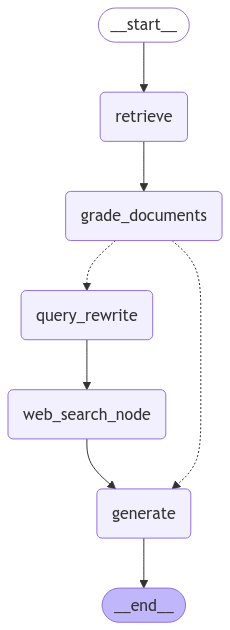

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Graph Execution

Now, execute the graph and check the results. This explains how to stream results in a RAG application.

There are two streaming output modes for the graph: `messages` and `updates`. These can be controlled by specifying the `stream_mode` parameter.

- `stream_mode="updates"`: Typically streams during the call steps,  meaning updates to the state of individual nodes. In this case, each node simply adds a new key to the state.

- `stream_mode="messages"`: Streams tokens from a chat model call.

- [Langchain: stream_mode](https://python.langchain.com/docs/how_to/qa_streaming/)


The following explains the output method for stream_mode="updates"

In [18]:
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

# Configure settings (maximum recursion limit, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid4()})

# Input question
inputs = {
    "question": "How do agents differ from standalone language models?",
}
# Execute the graph in update format.
for output in app.stream(inputs, config, stream_mode="updates"):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        #print(value)
    print("\n---\n")
    
print(value["generation"])


==== RETRIEVE ====

Output from node 'retrieve':
---

---


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: GENERATE] ====
Output from node 'grade_documents':
---

---


==== GENERATE ====

Output from node 'generate':
---

---

Agents differ from standalone language models in that they can leverage external tools to access real-time information and perform complex tasks autonomously. While language models are limited to their training data, agents can extend their knowledge through connections with external systems. This allows agents to execut

The following explains the output method for stream_mode="messages"

In [19]:
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

# Configure settings (maximum recursion limit, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid4()})

# Input question
inputs = {
    "question": "List up the name of the authors.",
}

for message, metadata in app.stream(
    inputs, config, 
    stream_mode="messages",
):
    if metadata["langgraph_node"] == "generate":
        print(message.content, end="", flush=True)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: GENERATE] ====

==== GENERATE ====



In the output above, since the question was relevant to the document, it directly connects to the `generation` node.

This time, the question is not relevant to the document. Therefore, it connects to the `query_rewrite` node and then to the `web_search` node.

In other words, if the grade_documents node determines that no document is relevant, it connects to the `web_search` node.

Here is the output for `stream_mode="messages"`.

In [20]:
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

# Configure settings (maximum recursion limit, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid4()})

# Input question
inputs = {
    "question": "What is CRAG?",
}

for message, metadata in app.stream(
    inputs, config, 
    stream_mode="messages",
):
    if metadata["langgraph_node"] == "generate":
        print(message.content, end="", flush=True)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

==== [REWRITE QUERY] ====


==== [WEB SEARCH] ====


==== GENERATE ====

